In [1]:
!pip install transformers tensorflow scikit-learn matplotlib seaborn -U
!pip install pickle5


  Using cached transformers-4.41.2-py3-none-any.whl.metadata (43 kB)
  Using cached filelock-3.14.0-py3-none-any.whl.metadata (2.8 kB)
  Using cached huggingface_hub-0.23.3-py3-none-any.whl.metadata (12 kB)
     ---------------------------------------- 0.0/42.0 kB ? eta -:--:--
     --------------------------- ---------- 30.7/42.0 kB 640.0 kB/s eta 0:00:01
     -------------------------------------- 42.0/42.0 kB 675.2 kB/s eta 0:00:00
  Using cached tqdm-4.66.4-py3-none-any.whl.metadata (57 kB)
Using cached transformers-4.41.2-py3-none-any.whl (9.1 MB)
   ---------------------------------------- 0.0/10.9 MB ? eta -:--:--
    --------------------------------------- 0.2/10.9 MB 4.6 MB/s eta 0:00:03
   -- ------------------------------------- 0.6/10.9 MB 7.4 MB/s eta 0:00:02
   ----- ---------------------------------- 1.4/10.9 MB 11.4 MB/s eta 0:00:01
   --------- ------------------------------ 2.5/10.9 MB 14.3 MB/s eta 0:00:01
   ------------ --------------------------- 3.5/10.9 MB 16.0 

  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [58 lines of output]
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build\lib.win-amd64-cpython-312
      creating build\lib.win-amd64-cpython-312\pickle5
      copying pickle5\pickle.py -> build\lib.win-amd64-cpython-312\pickle5
      copying pickle5\pickletools.py -> build\lib.win-amd64-cpython-312\pickle5
      copying pickle5\__init__.py -> build\lib.win-amd64-cpython-312\pickle5
      creating build\lib.win-amd64-cpython-312\pickle5\test
      copying pickle5\test\pickletester.py -> build\lib.win-amd64-cpython-312\pickle5\test
      copying pickle5\test\test_pickle.py -> build\lib.win-amd64-cpython-312\pickle5\test
      copying pickle5\test\test_picklebuffer.py -> build\lib.win-amd64-cpython-312\pickle5\test
      copying pickle5\test\__init__.py -> build\lib.win-amd64-cpython-312\pickle5\test
      run

In [3]:
pip install tf-keras


  Using cached tf_keras-2.16.0-py3-none-any.whl.metadata (1.6 kB)
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
    --------------------------------------- 0.0/1.7 MB 495.5 kB/s eta 0:00:04
   ----- ---------------------------------- 0.3/1.7 MB 2.0 MB/s eta 0:00:01
   ------------------- -------------------- 0.8/1.7 MB 4.9 MB/s eta 0:00:01
   ---------------------------------------  1.7/1.7 MB 8.4 MB/s eta 0:00:01
   ---------------------------------------- 1.7/1.7 MB 7.9 MB/s eta 0:00:00


In [4]:
import tensorflow as tf
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
from transformers import RobertaTokenizer, TFRobertaForSequenceClassification
import pickle
import pandas as pd
import numpy as np
import time

In [5]:

# Memuat DistilBERT
distilbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-cased')
distilbert_model = TFDistilBertForSequenceClassification.from_pretrained('./distilbert/saved_model')

# Memuat RoBERTa
roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
roberta_model = TFRobertaForSequenceClassification.from_pretrained('./roberta/saved_model')

d:\Software\Python\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


All model checkpoint layers were used when initializing TFDistilBertForSequenceClassification.

All the layers of TFDistilBertForSequenceClassification were initialized from the model checkpoint at ./distilbert/saved_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at ./roberta/saved_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


In [7]:
# Memuat encodings dan label
with open('category_to_id.pkl', 'rb') as f:
    category_to_id = pickle.load(f)

with open('id_to_category.pkl', 'rb') as f:
    id_to_category = pickle.load(f)

In [8]:
# Load validation data from CSV
val_data = pd.read_csv('expenses_2.csv')
val_data = val_data.dropna(subset=['Category', 'Note'])
val_data['label'] = val_data['Category'].map(category_to_id)

val_data = val_data.dropna(subset=['label'])

val_texts = val_data['Note'].tolist()
val_labels = val_data['label'].tolist()

# Tokenize the texts
distilbert_val_encodings = distilbert_tokenizer(val_texts, truncation=True, padding=True)
roberta_val_encodings = roberta_tokenizer(val_texts, truncation=True, padding=True)

# Convert to tf.data.Dataset
distilbert_val_dataset = tf.data.Dataset.from_tensor_slices((dict(distilbert_val_encodings), val_labels)).batch(16)
roberta_val_dataset = tf.data.Dataset.from_tensor_slices((dict(roberta_val_encodings), val_labels)).batch(16)


In [9]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score, roc_auc_score

# Fungsi untuk evaluasi
def evaluate_model_extended(model, val_dataset, val_labels):
    start_time = time.time()
    val_predictions = model.predict(val_dataset)
    inference_time = time.time() - start_time

    val_pred_probs = tf.nn.softmax(val_predictions.logits, axis=1).numpy()
    val_pred_labels = tf.argmax(val_predictions.logits, axis=1).numpy()

    accuracy = accuracy_score(val_labels, val_pred_labels)
    precision = precision_score(val_labels, val_pred_labels, average='weighted')
    recall = recall_score(val_labels, val_pred_labels, average='weighted')
    f1 = f1_score(val_labels, val_pred_labels, average='weighted')
    roc_auc = roc_auc_score(tf.keras.utils.to_categorical(val_labels), val_pred_probs, multi_class='ovr')
    conf_matrix = confusion_matrix(val_labels, val_pred_labels)
    class_report = classification_report(val_labels, val_pred_labels, target_names=[id_to_category[idx] for idx in range(len(category_to_id))])

    return accuracy, precision, recall, f1, roc_auc, inference_time, conf_matrix, class_report


In [10]:
# Evaluasi DistilBERT
(distilbert_accuracy, distilbert_precision, distilbert_recall, distilbert_f1, distilbert_roc_auc,
 distilbert_inference_time, distilbert_conf_matrix, distilbert_class_report) = evaluate_model_extended(distilbert_model, distilbert_val_dataset, val_labels)



728/728 [==============================] - 154s 196ms/step


In [11]:
# Evaluasi RoBERTa
(roberta_accuracy, roberta_precision, roberta_recall, roberta_f1, roberta_roc_auc,
 roberta_inference_time, roberta_conf_matrix, roberta_class_report) = evaluate_model_extended(roberta_model, roberta_val_dataset, val_labels)

728/728 [==============================] - 192s 251ms/step


In [12]:
import pandas as pd

# Membuat DataFrame untuk menyusun hasil evaluasi
results = {
    "Metric": ["Accuracy", "Precision", "Recall", "F1 Score", "ROC AUC", "Inference Time (s)"],
    "DistilBERT": [distilbert_accuracy, distilbert_precision, distilbert_recall, distilbert_f1, distilbert_roc_auc, distilbert_inference_time],
    "RoBERTa": [roberta_accuracy, roberta_precision, roberta_recall, roberta_f1, roberta_roc_auc, roberta_inference_time]
}

results_df = pd.DataFrame(results)
results_df

,Metric,DistilBERT,RoBERTa
0,Accuracy,0.989430,0.985391
1,Precision,0.989495,0.985347
2,Recall,0.989430,0.985391
3,F1 Score,0.989422,0.985325
4,ROC AUC,0.999749,0.999386
5,Inference Time (s),154.080989,192.063909


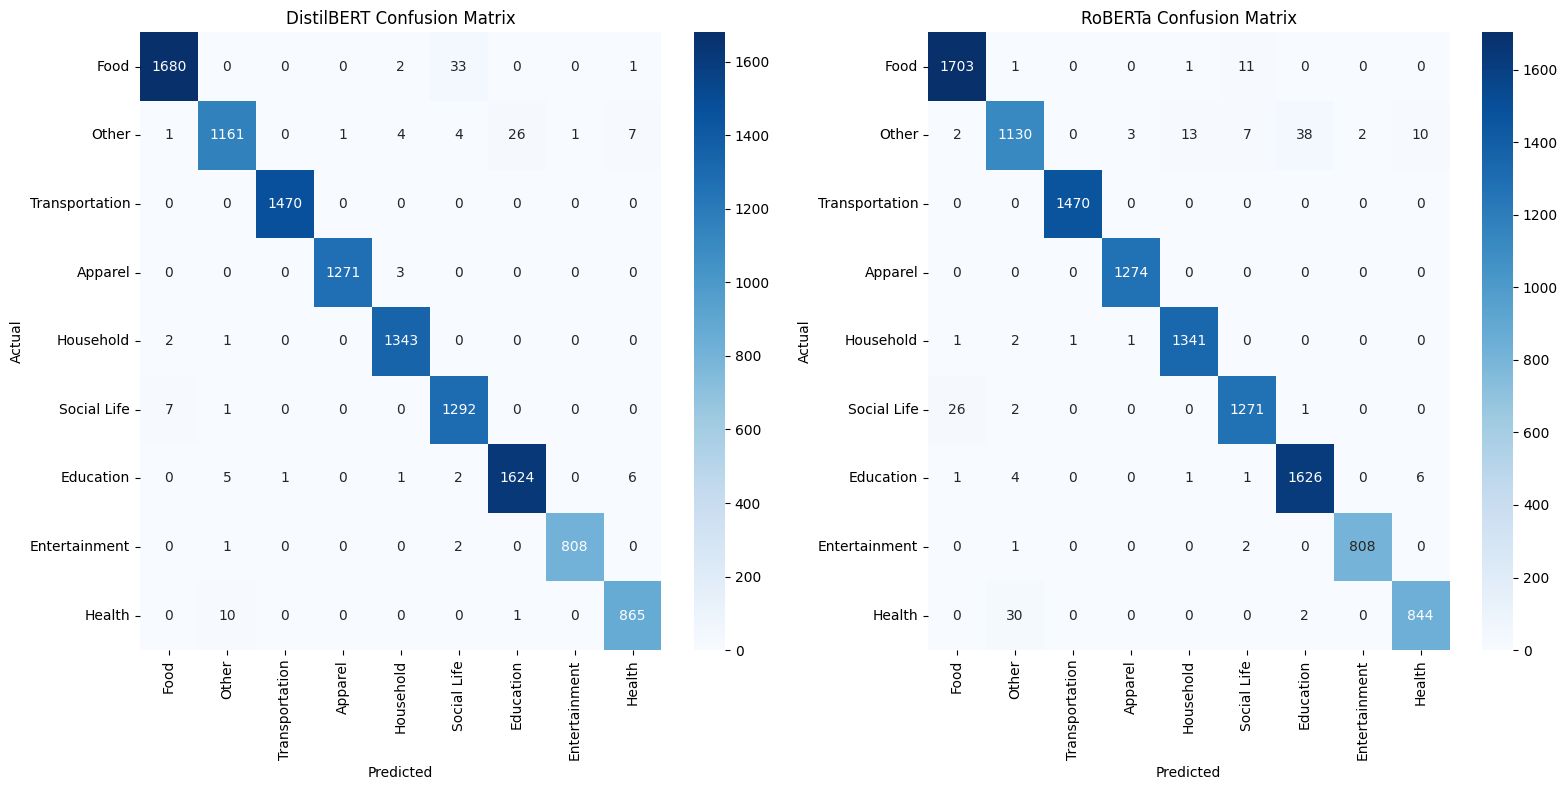

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

sns.heatmap(distilbert_conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[0], xticklabels=[id_to_category[idx] for idx in range(len(category_to_id))], yticklabels=[id_to_category[idx] for idx in range(len(category_to_id))])
axes[0].set_title('DistilBERT Confusion Matrix')
axes[0].set_ylabel('Actual')
axes[0].set_xlabel('Predicted')

sns.heatmap(roberta_conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[1], xticklabels=[id_to_category[idx] for idx in range(len(category_to_id))], yticklabels=[id_to_category[idx] for idx in range(len(category_to_id))])
axes[1].set_title('RoBERTa Confusion Matrix')
axes[1].set_ylabel('Actual')
axes[1].set_xlabel('Predicted')

plt.tight_layout()
plt.show()